# Get OT/PT time from chartevents

In [1]:
import pandas as pd
import glob

chunk_path = "/gpfs/gibbs/pi/zhao_yize/jl4286/chartevents/chunks/*.csv"

ot_records = []
pt_records = []

file_list = glob.glob(chunk_path)
print(f"Found {len(file_list)} chunk files. Processing...")

for i, file in enumerate(file_list):
    df = pd.read_csv(file) 

    # Filter for OT and PT consults
    ot_df = df[(df["itemid"] == 225135) & (df["value"] == "OT")]
    pt_df = df[(df["itemid"] == 225135) & (df["value"] == "PT")]

    if not ot_df.empty:
        ot_records.append(ot_df)
    if not pt_df.empty:
        pt_records.append(pt_df)

Found 4330 chunk files. Processing...


In [2]:
if ot_records:
    all_ot = pd.concat(ot_records, ignore_index=True)
    all_ot.to_csv("gpfs/gibbs/project/zhao_yize/jl4286/jain/ot_consult.csv", index=False)
    print("Saved OT records to ot_consult.csv")

if pt_records:
    all_pt = pd.concat(pt_records, ignore_index=True)
    all_pt.to_csv("gpfs/gibbs/project/zhao_yize/jl4286/jain/pt_consult.csv", index=False)
    print("Saved PT records to pt_consult.csv")

Saved OT records to ot_consult.csv
Saved PT records to pt_consult.csv


## Convert OT/PT time from Eastern to UTC

In [7]:
import pandas as pd

ot_df = pd.read_csv("/gpfs/gibbs/project/zhao_yize/jl4286/jain/ot_consult.csv", parse_dates=["ot_time"])
pt_df = pd.read_csv("/gpfs/gibbs/project/zhao_yize/jl4286/jain/pt_consult.csv", parse_dates=["pt_time"])

In [8]:
def convert_tz_to_utc(series: pd.Series) -> pd.Series:
    """
    Convert a series of timestamps to UTC.
    """
    MIMIC_TZ = "US/Eastern"
    series = series.dt.tz_localize(MIMIC_TZ, ambiguous="NaT", nonexistent="shift_forward")
    return series.dt.tz_convert("UTC")

ot_df["ot_time"] = convert_tz_to_utc(ot_df["ot_time"])
ot_df["ot_time"] = ot_df["ot_time"].dt.tz_localize(None)

ot_df["storetime"] = pd.to_datetime(ot_df["storetime"])
ot_df["storetime"] = convert_tz_to_utc(ot_df["storetime"])
ot_df["storetime"] = ot_df["storetime"].dt.tz_localize(None)

pt_df["pt_time"] = convert_tz_to_utc(pt_df["pt_time"])
pt_df["pt_time"] = pt_df["pt_time"].dt.tz_localize(None)

pt_df["storetime"] = pd.to_datetime(pt_df["storetime"])
pt_df["storetime"] = convert_tz_to_utc(pt_df["storetime"])
pt_df["storetime"] = pt_df["storetime"].dt.tz_localize(None)

ot_df.head()

,subject_id,hadm_id,stay_id,caregiver_id,ot_time,storetime,itemid,value,valuenum,valueuom,warning,patient_id
0,19728994,24060875,30033179,17762.0,2157-08-06 11:51:00,2157-08-06 11:55:00,225135,OT,NaN,NaN,0.0,19728994
1,13972513,22100555,30479593,60065.0,2206-04-25 23:05:00,2206-04-25 23:07:00,225135,OT,NaN,NaN,0.0,13972513
2,13972513,23459760,33155916,32954.0,2206-04-08 06:57:00,2206-04-08 07:01:00,225135,OT,NaN,NaN,0.0,13972513
3,10230936,20449497,34698361,26099.0,2111-08-05 03:27:00,2111-08-05 03:30:00,225135,OT,NaN,NaN,0.0,10230936
4,10230936,20449497,34698361,26099.0,2111-08-05 05:27:00,2111-08-05 05:28:00,225135,OT,NaN,NaN,0.0,10230936


In [9]:
ot_df.to_csv("/gpfs/gibbs/project/zhao_yize/jl4286/jain/ot_consult_utc.csv", index=False)
pt_df.to_csv("/gpfs/gibbs/project/zhao_yize/jl4286/jain/pt_consult_utc.csv", index=False)

# Merge OT/PT times into final_df

In [2]:
import pandas as pd

ot_df = pd.read_csv("/gpfs/gibbs/project/zhao_yize/jl4286/jain/ot_consult_utc.csv", parse_dates=["ot_time"])
pt_df = pd.read_csv("/gpfs/gibbs/project/zhao_yize/jl4286/jain/pt_consult_utc.csv", parse_dates=["pt_time"])

In [3]:
# This file is from 02_mobilization_analysis notebook that contains the criteria flag variables
final_df = pd.read_parquet("/gpfs/gibbs/project/zhao_yize/jl4286/CLIF-eligibility-for-mobilization/output/intermediate/final_df_full_eligibility.parquet")

In [4]:
#final_df.columns.tolist()
#"min_fio2_set", "max_fio2_set", "min_peep_set", "max_peep_set", "min_lpm_set", "max_lpm_set",
#                'min_resp_rate_obs', 'max_resp_rate_obs','max_dbp','max_heart_rate','max_height_cm', 'max_map',
#                'max_respiratory_rate', 'max_sbp', 'max_spo2', 'max_weight_kg', 'min_dbp', 'min_heart_rate',
#                'min_height_cm', 'min_map', 'min_respiratory_rate', 'min_sbp', 'min_spo2', 'min_weight_kg',
#               'ne_calc_min', 'ne_calc_max', 'min_ne_dose_last_6_hours', 'nicardipine_flag',
#                'nitroprusside_flag', 'clevidipine_flag','red_meds_flag','cisatracurium_flag',
#                'vecuronium_flag','rocuronium_flag','paralytics_flag','lactate',

### Drop irrelevant information
cols_to_drop = ['patel_map_flag',
                'patel_sbp_flag','patel_pulse_flag','patel_resp_rate_flag','patel_spo2_flag','patel_resp_flag',
                'patel_cardio_flag','team_pulse_flag','team_lactate_flag','team_ne_flag','team_fio2_flag',
                'team_peep_flag','team_resp_rate_flag','team_cardio_flag','team_resp_flag',
                'red_resp_spo2_flag','red_map_flag','red_high_support_flag','red_hypertensive_flag',
                'red_pulse_high_flag','red_pulse_low_flag','yellow_resp_spo2_flag','yellow_fio2_flag',
                'yellow_resp_rate_flag','yellow_peep_flag','yellow_map_flag','yellow_pulse_flag',
                'yellow_lactate_flag','green_resp_spo2_flag','green_resp_rate_flag','green_fio2_flag',
                'green_peep_flag','green_map_flag','green_pulse_flag','green_lactate_flag','green_hr_flag',
                'yellow_resp_flag','yellow_cardio_flag']

final_df = final_df.drop(columns=cols_to_drop)

In [5]:
final_df.to_parquet("/gpfs/gibbs/project/zhao_yize/jl4286/jain/final_df.parquet")

In [6]:
# Make sure the type of patient_id is str across three datasets
ot_df["patient_id"] = ot_df["subject_id"].astype(str)
pt_df["patient_id"] = pt_df["subject_id"].astype(str)
final_df["patient_id"] = final_df["patient_id"].astype(str)

In [7]:
# Create floored hourly time for matching
ot_df["OT_hour"] = ot_df["ot_time"].dt.floor("h")
pt_df["PT_hour"] = pt_df["pt_time"].dt.floor("h")

In [8]:
# Create index for sorted OT/PT consults
ot_df = (
    ot_df
    .sort_values(["patient_id", "ot_time"])
    .assign(OT_seq=lambda d: d.groupby("patient_id").cumcount() + 1)
)

pt_df = (
    pt_df
    .sort_values(["patient_id", "pt_time"])
    .assign(PT_seq=lambda d: d.groupby("patient_id").cumcount()+1))

In [9]:
max_ot = int(ot_df["OT_seq"].max()) if not ot_df.empty else 0
max_pt = int(pt_df["PT_seq"].max()) if not pt_df.empty else 0
print(max_ot)
print(max_pt)

14
30


In [10]:
ot_df[ot_df["patient_id"]=="10005606"].head()

,subject_id,hadm_id,stay_id,caregiver_id,ot_time,storetime,itemid,value,valuenum,valueuom,warning,patient_id,OT_hour,OT_seq
5410,10005606,29646384,38740124,90069.0,2143-12-06 07:22:00,2143-12-06 07:28:00,225135,OT,NaN,NaN,0.0,10005606,2143-12-06 07:00:00,1
5407,10005606,29646384,38740124,78864.0,2143-12-06 07:29:00,2143-12-06 07:29:00,225135,OT,NaN,NaN,0.0,10005606,2143-12-06 07:00:00,2
5405,10005606,29646384,38740124,32207.0,2143-12-06 17:35:00,2143-12-06 17:37:00,225135,OT,NaN,NaN,0.0,10005606,2143-12-06 17:00:00,3
5408,10005606,29646384,38740124,78864.0,2143-12-08 19:18:00,2143-12-08 19:22:00,225135,OT,NaN,NaN,0.0,10005606,2143-12-08 19:00:00,4
5406,10005606,29646384,38740124,63049.0,2143-12-09 02:15:00,2143-12-09 02:15:00,225135,OT,NaN,NaN,0.0,10005606,2143-12-09 02:00:00,5


In [11]:
final_df[final_df["patient_id"]== "10005606"].head()

,patient_id,hospitalization_id,encounter_block,recorded_dttm,recorded_date,recorded_hour,time_from_vent,time_from_vent_adjusted,min_fio2_set,max_fio2_set,...,any_yellow,any_green,all_green,all_green_no_red,all_green_no_red_yellow,all_yellow_no_red_green,any_yellow_no_red_green,any_yellow_or_green_no_red,yellow_all_green,yellow_not_all_green
2753,10005606,29646384,50,2143-12-06 22:00:00,2143-12-06,22,0,-1,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2754,10005606,29646384,50,2143-12-06 23:00:00,2143-12-06,23,1,-1,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2755,10005606,29646384,50,2143-12-07 00:00:00,2143-12-07,0,2,-1,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2756,10005606,29646384,50,2143-12-07 01:00:00,2143-12-07,1,3,-1,0.4,0.4,...,0,0,0,0,0,0,0,0,0,0
2757,10005606,29646384,50,2143-12-07 02:00:00,2143-12-07,2,4,0,0.4,0.4,...,0,0,0,0,0,0,0,0,0,0


In [12]:
final_df["recorded_dttm"] = pd.to_datetime(final_df["recorded_dttm"])
final_df["dttm_hour"] = final_df["recorded_dttm"].dt.floor("h")

In [13]:
# For each OT record, merge back a flag and exact time
for i in range(1, max_ot + 1):
    tmp = (
        ot_df[ot_df["OT_seq"] == i]
        [["patient_id", "OT_hour", "ot_time"]]
        .rename(columns={
            "OT_hour": "dttm_hour",
            "ot_time": f"ot_time{i}"
        })
    )
    tmp[f"ot_flag{i}"] = 1

    final_df = final_df.merge(
        tmp,
        on=["patient_id", "dttm_hour"],
        how="left"
    )

    # Only set 0 for those who had an i-th consult
    patients_with_i = tmp["patient_id"].unique()
    mask = final_df["patient_id"].isin(patients_with_i)

    # Those who didn't have i-th consult, has NaN values. 
    final_df.loc[mask, f"ot_flag{i}"] = final_df.loc[mask, f"ot_flag{i}"].fillna(0).astype(int)

In [14]:
for i in range(1, max_pt + 1):
    tmp = (
        pt_df[pt_df["PT_seq"] == i]
        [["patient_id", "PT_hour", "pt_time"]]
        .rename(columns={
            "PT_hour": "dttm_hour",
            "pt_time": f"pt_time{i}"
        })
    )
    tmp[f"pt_flag{i}"] = 1

    final_df = final_df.merge(
        tmp,
        on=["patient_id", "dttm_hour"],
        how="left"
    )

    patients_with_i = tmp["patient_id"].unique()
    mask = final_df["patient_id"].isin(patients_with_i)

    final_df.loc[mask, f"pt_flag{i}"] = final_df.loc[mask, f"pt_flag{i}"].fillna(0).astype(int)

In [15]:
# Build the overall per‐hour flags
ot_flags = [col for col in final_df.columns if col.startswith("ot_flag") and col.replace("ot_flag", "").isdigit()]
final_df["OT_flag"] = final_df[ot_flags].max(axis=1)

pt_flags = [col for col in final_df.columns if col.startswith("pt_flag") and col.replace("pt_flag", "").isdigit()]
final_df["PT_flag"] = final_df[pt_flags].max(axis=1)

In [16]:
final_df.head()

,patient_id,hospitalization_id,encounter_block,recorded_dttm,recorded_date,recorded_hour,time_from_vent,time_from_vent_adjusted,min_fio2_set,max_fio2_set,...,pt_time27,pt_flag27,pt_time28,pt_flag28,pt_time29,pt_flag29,pt_time30,pt_flag30,OT_flag,PT_flag
0,10001884,26184834,8,2131-01-11 09:00:00,2131-01-11,9,0,-1,1.0,1.0,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,0.0,0.0
1,10001884,26184834,8,2131-01-11 10:00:00,2131-01-11,10,1,-1,1.0,1.0,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,0.0,0.0
2,10001884,26184834,8,2131-01-11 11:00:00,2131-01-11,11,2,-1,1.0,1.0,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,0.0,0.0
3,10001884,26184834,8,2131-01-11 12:00:00,2131-01-11,12,3,-1,0.5,0.5,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,0.0,0.0
4,10001884,26184834,8,2131-01-11 13:00:00,2131-01-11,13,4,0,0.5,0.5,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,0.0,0.0


In [17]:
# Remove duplicates
final_df = final_df.drop_duplicates(
    subset=["patient_id", "ot_flag1", "ot_time1", "recorded_dttm", "dttm_hour"]
)

final_df.to_parquet("/gpfs/gibbs/project/zhao_yize/jl4286/jain/final_df_OT_PT.parquet")

## Problem: 
In my previous work, I merged the datasets based on recorded_dttm. Here, some of the first OT was delivered ealier than the earliest recorded_dttm in the final_df for that patient.  

## Sol: 
Step 1: Look for the exact datetime for ventilation start time.   
Step 2: Create a variable "ot_postvent_1" that takes a value of 1 if the first OT was delivered before ventilation and 0 otherwise, same for "pt_postvent_1". 

In [1]:
import pandas as pd
final_df = pd.read_parquet("/gpfs/gibbs/project/zhao_yize/jl4286/jain/final_df_OT_PT.parquet")

In [18]:
# Identify each block’s ventilation start time
vent_start = (
    final_df
    .loc[final_df["time_from_vent"] == 0, ["patient_id", "encounter_block", "recorded_dttm"]]
    .drop_duplicates()
    .rename(columns={"recorded_dttm": "vent_start_time"})
)
vent_start

,patient_id,encounter_block,vent_start_time
0,10001884,8,2131-01-11 09:00:00
217,10002013,9,2160-05-18 19:00:00
244,10002114,11,2162-02-18 04:00:00
313,10002428,16,2156-04-20 01:00:00
480,10002428,18,2156-05-11 21:00:00
...,...,...,...
4850706,19999068,85240,2161-08-25 20:35:00
4850832,19999287,85242,2197-08-07 01:00:00
4850877,19999442,85244,2148-11-20 00:27:00
4851037,19999840,85247,2164-09-12 14:26:00


In [19]:
# Convert ot_times into long format
ot_time_cols = [f"ot_time{i}" for i in range(1, 15)]
ot_melt = (
    final_df[["patient_id", "encounter_block"] + ot_time_cols]
    .melt(
        id_vars=["patient_id", "encounter_block"],
        value_vars=ot_time_cols,
        var_name="ot_seq",
        value_name="consult_time",
    )
    .dropna(subset=["consult_time"])
)
ot_melt

,patient_id,encounter_block,ot_seq,consult_time
14,10001884,8,ot_time1,2131-01-11 23:37:00
2395,10004720,44,ot_time1,2186-11-13 04:49:00
4028,10010867,88,ot_time1,2147-12-30 15:23:00
6408,10014610,130,ot_time1,2173-12-21 00:03:00
7115,10017285,151,ot_time1,2166-05-05 23:23:00
...,...,...,...,...
59572052,12952453,24980,ot_time13,2175-10-23 22:51:00
59772370,13386388,28773,ot_time13,2171-09-15 01:33:00
60746034,15435089,46335,ot_time13,2131-07-10 11:57:00
64214015,12532250,21382,ot_time14,2129-10-14 09:09:00


In [20]:
# Attach the vent start to each melt‐row, and keep only those after vent start
ot_melt = (
    ot_melt
    .merge(vent_start, on=["patient_id", "encounter_block"], how="left")
    .query("consult_time > vent_start_time")
)

In [21]:
# For each block, pick the earliest consult_time
first_ot = (
    ot_melt
    .sort_values("consult_time")
    .groupby(["patient_id", "encounter_block"], as_index=False)
    .first()[["patient_id", "encounter_block", "consult_time"]]
    .rename(columns={"consult_time": "first_ot_postvent_time"})
)
first_ot

,patient_id,encounter_block,first_ot_postvent_time
0,10001884,8,2131-01-11 23:37:00
1,10004720,44,2186-11-13 04:49:00
2,10005606,50,2143-12-08 19:18:00
3,10010867,88,2147-12-30 15:23:00
4,10014610,130,2173-12-21 00:03:00
...,...,...,...
1597,19965802,84939,2128-06-14 08:29:00
1598,19968039,84955,2132-04-21 10:14:00
1599,19970265,84975,2115-03-29 13:12:00
1600,19989440,85137,2167-04-20 09:14:00


In [22]:
# Merge back onto final_df
final_df = final_df.merge(
    first_ot,
    on=["patient_id", "encounter_block"],
    how="left"
)

# Build the indicator: wherever any ot_time{i} equals that first time, flag 1
final_df["ot_postvent_1"] = 0
for i in range(1, 15):
    final_df.loc[
        final_df[f"ot_time{i}"] == final_df["first_ot_postvent_time"],
        "ot_postvent_1"
    ] = 1

#final_df.drop("first_ot_postvent_time", axis=1, inplace=True)

,patient_id,hospitalization_id,encounter_block,recorded_dttm,recorded_date,recorded_hour,time_from_vent,time_from_vent_adjusted,min_fio2_set,max_fio2_set,...,pt_time28,pt_flag28,pt_time29,pt_flag29,pt_time30,pt_flag30,OT_flag,PT_flag,first_ot_postvent_time,ot_postvent_1
0,10001884,26184834,8,2131-01-11 09:00:00,2131-01-11,9,0,-1,1.0,1.0,...,NaT,NaN,NaT,NaN,NaT,NaN,0.0,0.0,2131-01-11 23:37:00,0
1,10001884,26184834,8,2131-01-11 10:00:00,2131-01-11,10,1,-1,1.0,1.0,...,NaT,NaN,NaT,NaN,NaT,NaN,0.0,0.0,2131-01-11 23:37:00,0
2,10001884,26184834,8,2131-01-11 11:00:00,2131-01-11,11,2,-1,1.0,1.0,...,NaT,NaN,NaT,NaN,NaT,NaN,0.0,0.0,2131-01-11 23:37:00,0
3,10001884,26184834,8,2131-01-11 12:00:00,2131-01-11,12,3,-1,0.5,0.5,...,NaT,NaN,NaT,NaN,NaT,NaN,0.0,0.0,2131-01-11 23:37:00,0
4,10001884,26184834,8,2131-01-11 13:00:00,2131-01-11,13,4,0,0.5,0.5,...,NaT,NaN,NaT,NaN,NaT,NaN,0.0,0.0,2131-01-11 23:37:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4845062,19999987,23865745,85248,2145-11-04 22:00:00,2145-11-04,22,42,38,0.4,0.4,...,NaT,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaT,0
4845063,19999987,23865745,85248,2145-11-04 23:00:00,2145-11-04,23,43,39,0.4,0.4,...,NaT,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaT,0
4845064,19999987,23865745,85248,2145-11-05 00:00:00,2145-11-05,0,44,40,0.4,0.4,...,NaT,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaT,0
4845065,19999987,23865745,85248,2145-11-05 01:00:00,2145-11-05,1,45,41,0.4,0.4,...,NaT,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaT,0


### Same steps for PT

In [25]:
pt_time_cols = [f"pt_time{i}" for i in range(1, 31)]
pt_melt = (
    final_df[["patient_id", "encounter_block"] + pt_time_cols]
    .melt(
        id_vars=["patient_id", "encounter_block"],
        value_vars=pt_time_cols,
        var_name="pt_seq",
        value_name="consult_time",
    )
    .dropna(subset=["consult_time"])
)
pt_melt

,patient_id,encounter_block,pt_seq,consult_time
14,10001884,8,pt_time1,2131-01-11 23:37:00
745,10002760,23,pt_time1,2141-04-20 22:50:00
2395,10004720,44,pt_time1,2186-11-13 04:49:00
4028,10010867,88,pt_time1,2147-12-30 15:23:00
4437,10011365,92,pt_time1,2166-02-12 03:27:00
...,...,...,...,...
86101491,17694075,65547,pt_time18,2182-08-12 11:59:00
87887878,11390058,11772,pt_time19,2130-12-06 12:05:00
90552700,16892349,58711,pt_time19,2147-10-15 21:53:00
90946682,17694075,65547,pt_time19,2182-08-17 15:57:00


In [26]:
pt_melt = (
    pt_melt
    .merge(vent_start, on=["patient_id", "encounter_block"], how="left")
    .query("consult_time > vent_start_time")
)

first_pt = (
    pt_melt
    .sort_values("consult_time")
    .groupby(["patient_id", "encounter_block"], as_index=False)
    .first()[["patient_id", "encounter_block", "consult_time"]]
    .rename(columns={"consult_time": "first_pt_postvent_time"})
)
first_pt

,patient_id,encounter_block,first_pt_postvent_time
0,10001884,8,2131-01-11 23:37:00
1,10002760,23,2141-04-20 22:50:00
2,10004422,41,2111-01-17 22:50:00
3,10004720,44,2186-11-13 04:49:00
4,10005348,48,2130-10-28 03:24:00
...,...,...,...
4254,19989305,85135,2154-05-15 00:12:00
4255,19989437,85136,2181-09-15 01:54:00
4256,19989440,85137,2167-04-20 09:14:00
4257,19991135,85158,2126-09-09 04:16:00


In [27]:
final_df = final_df.merge(
    first_pt,
    on=["patient_id", "encounter_block"],
    how="left"
)

final_df["pt_postvent_1"] = 0
for i in range(1, 31):
    final_df.loc[
        final_df[f"pt_time{i}"] == final_df["first_pt_postvent_time"],
        "pt_postvent_1"
    ] = 1

In [29]:
final_df[final_df["patient_id"]== "10004720"].head()

,patient_id,hospitalization_id,encounter_block,recorded_dttm,recorded_date,recorded_hour,time_from_vent,time_from_vent_adjusted,min_fio2_set,max_fio2_set,...,pt_time29,pt_flag29,pt_time30,pt_flag30,OT_flag,PT_flag,first_ot_postvent_time,ot_postvent_1,first_pt_postvent_time,pt_postvent_1
2392,10004720,22081550,44,2186-11-13 01:00:00,2186-11-13,1,0,-1,0.5,0.5,...,NaT,NaN,NaT,NaN,0.0,0.0,2186-11-13 04:49:00,0,2186-11-13 04:49:00,0
2393,10004720,22081550,44,2186-11-13 02:00:00,2186-11-13,2,1,-1,0.5,0.5,...,NaT,NaN,NaT,NaN,0.0,0.0,2186-11-13 04:49:00,0,2186-11-13 04:49:00,0
2394,10004720,22081550,44,2186-11-13 03:00:00,2186-11-13,3,2,-1,0.5,0.5,...,NaT,NaN,NaT,NaN,0.0,0.0,2186-11-13 04:49:00,0,2186-11-13 04:49:00,0
2395,10004720,22081550,44,2186-11-13 04:00:00,2186-11-13,4,3,-1,0.5,0.5,...,NaT,NaN,NaT,NaN,1.0,1.0,2186-11-13 04:49:00,1,2186-11-13 04:49:00,1
2396,10004720,22081550,44,2186-11-13 05:00:00,2186-11-13,5,4,0,0.5,0.5,...,NaT,NaN,NaT,NaN,0.0,0.0,2186-11-13 04:49:00,0,2186-11-13 04:49:00,0


In [30]:
pt_time_cols = [f"pt_time{i}" for i in range(2, 31)]
ot_time_cols = [f"ot_time{i}" for i in range(2, 15)]
pt_flag_cols = [f"pt_flag{i}" for i in range(2, 31)]
ot_flag_cols = [f"ot_flag{i}" for i in range(2, 15)]

final_df = final_df.drop(columns=pt_time_cols + ot_time_cols + pt_flag_cols + ot_flag_cols)

final_df.to_parquet("/gpfs/gibbs/project/zhao_yize/jl4286/jain/final_df_first_OT_PT.parquet")

In [5]:
final_df.head(20)

,patient_id,hospitalization_id,encounter_block,recorded_dttm,recorded_date,recorded_hour,time_from_vent,time_from_vent_adjusted,min_fio2_set,max_fio2_set,...,ot_time1,ot_flag1,pt_time1,pt_flag1,OT_flag,PT_flag,first_ot_postvent_time,ot_postvent_1,first_pt_postvent_time,pt_postvent_1
0,10001884,26184834,8,2131-01-11 09:00:00,2131-01-11,9,0,-1,1.0,1.0,...,NaT,0.0,NaT,0.0,0.0,0.0,2131-01-11 23:37:00,0,2131-01-11 23:37:00,0
1,10001884,26184834,8,2131-01-11 10:00:00,2131-01-11,10,1,-1,1.0,1.0,...,NaT,0.0,NaT,0.0,0.0,0.0,2131-01-11 23:37:00,0,2131-01-11 23:37:00,0
2,10001884,26184834,8,2131-01-11 11:00:00,2131-01-11,11,2,-1,1.0,1.0,...,NaT,0.0,NaT,0.0,0.0,0.0,2131-01-11 23:37:00,0,2131-01-11 23:37:00,0
3,10001884,26184834,8,2131-01-11 12:00:00,2131-01-11,12,3,-1,0.5,0.5,...,NaT,0.0,NaT,0.0,0.0,0.0,2131-01-11 23:37:00,0,2131-01-11 23:37:00,0
4,10001884,26184834,8,2131-01-11 13:00:00,2131-01-11,13,4,0,0.5,0.5,...,NaT,0.0,NaT,0.0,0.0,0.0,2131-01-11 23:37:00,0,2131-01-11 23:37:00,0
5,10001884,26184834,8,2131-01-11 14:00:00,2131-01-11,14,5,1,0.5,0.5,...,NaT,0.0,NaT,0.0,0.0,0.0,2131-01-11 23:37:00,0,2131-01-11 23:37:00,0
6,10001884,26184834,8,2131-01-11 15:00:00,2131-01-11,15,6,2,0.5,0.5,...,NaT,0.0,NaT,0.0,0.0,0.0,2131-01-11 23:37:00,0,2131-01-11 23:37:00,0
7,10001884,26184834,8,2131-01-11 16:00:00,2131-01-11,16,7,3,0.5,0.5,...,NaT,0.0,NaT,0.0,0.0,0.0,2131-01-11 23:37:00,0,2131-01-11 23:37:00,0
8,10001884,26184834,8,2131-01-11 17:00:00,2131-01-11,17,8,4,0.5,0.5,...,NaT,0.0,NaT,0.0,0.0,0.0,2131-01-11 23:37:00,0,2131-01-11 23:37:00,0
9,10001884,26184834,8,2131-01-11 18:00:00,2131-01-11,18,9,5,0.5,0.5,...,NaT,0.0,NaT,0.0,0.0,0.0,2131-01-11 23:37:00,0,2131-01-11 23:37:00,0


# Time to First OT/PT/Either

In [1]:
import pandas as pd

final_df = pd.read_parquet("/gpfs/gibbs/project/zhao_yize/jl4286/jain/final_df_first_OT_PT.parquet")

In [2]:
final_df[final_df["encounter_block"]== 9].head()

,patient_id,hospitalization_id,encounter_block,recorded_dttm,recorded_date,recorded_hour,time_from_vent,time_from_vent_adjusted,min_fio2_set,max_fio2_set,...,ot_time1,ot_flag1,pt_time1,pt_flag1,OT_flag,PT_flag,first_ot_postvent_time,ot_postvent_1,first_pt_postvent_time,pt_postvent_1
217,10002013,23581541,9,2160-05-18 19:00:00,2160-05-18,19,0,-1,1.0,1.0,...,NaT,NaN,NaT,NaN,NaN,NaN,NaT,0,NaT,0
218,10002013,23581541,9,2160-05-18 20:00:00,2160-05-18,20,1,-1,0.5,0.5,...,NaT,NaN,NaT,NaN,NaN,NaN,NaT,0,NaT,0
219,10002013,23581541,9,2160-05-18 21:00:00,2160-05-18,21,2,-1,1.0,1.0,...,NaT,NaN,NaT,NaN,NaN,NaN,NaT,0,NaT,0
220,10002013,23581541,9,2160-05-18 22:00:00,2160-05-18,22,3,-1,1.0,1.0,...,NaT,NaN,NaT,NaN,NaN,NaN,NaT,0,NaT,0
221,10002013,23581541,9,2160-05-18 23:00:00,2160-05-18,23,4,0,0.5,0.5,...,NaT,NaN,NaT,NaN,NaN,NaN,NaT,0,NaT,0


In [3]:
all_ids_w_outcome = pd.read_csv('/gpfs/gibbs/project/zhao_yize/jl4286/CLIF-eligibility-for-mobilization/output/intermediate/cohort_all_ids_w_outcome.csv')

all_ids_w_outcome.head()

,patient_id,hospitalization_id,encounter_block,block_vent_start_dttm,block_vent_end_dttm,block_first_vital_dttm,block_last_vital_dttm,discharge_dttm,discharge_category,death_dttm,final_outcome_dttm,is_dead
0,10001884,26184834,8,2131-01-11 09:00:00,2131-01-19 23:45:00,2131-01-11 09:20:00,2131-01-20 09:19:00,2131-01-20 10:15:00,Expired,2131-01-20 05:15:00,2131-01-20 09:19:00,1
1,10002013,23581541,9,2160-05-18 19:00:00,2160-05-18 23:00:00,2160-05-18 15:00:00,2160-05-19 21:00:00,2160-05-23 18:30:00,Home,NaN,2160-05-19 21:00:00,0
2,10002114,27793700,11,2162-02-18 04:00:00,2162-02-20 00:37:00,2162-02-18 03:33:00,2162-02-21 00:06:00,2162-03-04 20:16:00,Home,NaN,2162-02-21 00:06:00,0
3,10002428,28662225,16,2156-04-20 01:00:00,2156-04-22 21:00:00,2156-04-12 21:24:00,2156-04-26 23:00:00,2156-04-29 21:26:00,Skilled Nursing Facility (SNF),NaN,2156-04-26 23:00:00,0
4,10002428,23473524,18,2156-05-11 21:00:00,2156-05-20 14:00:00,2156-05-11 19:49:00,2156-05-22 18:00:00,2156-05-22 19:16:00,Long Term Care Hospital (LTACH),NaN,2156-05-22 18:00:00,0


In [4]:
all_ids_w_outcome["block_vent_start_dttm"] = pd.to_datetime(all_ids_w_outcome["block_vent_start_dttm"], errors='coerce')

# Merge block_vent_start_dttm into final_df by encounter_block
final_df = final_df.merge(
    all_ids_w_outcome[["encounter_block", "block_vent_start_dttm"]],
    on="encounter_block", how="left")

In [5]:
# Compute Time_to_first_OT in hours
delta_ot = final_df["first_ot_postvent_time"] - final_df["block_vent_start_dttm"]
final_df["Time_first_OT"] = (delta_ot.dt.round("H") / pd.Timedelta(hours=1)).astype("Int64")

delta_pt = final_df["first_pt_postvent_time"] - final_df["block_vent_start_dttm"]
final_df["Time_first_PT"] = (delta_pt.dt.round("H") / pd.Timedelta(hours=1)).astype("Int64")

final_df["Time_first_OT_or_PT"] = (
    final_df[["Time_first_OT", "Time_first_PT"]]
    .min(axis=1)
)

/tmp/ipykernel_1464428/3266019149.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  final_df["Time_first_OT"] = (delta_ot.dt.round("H") / pd.Timedelta(hours=1)).astype("Int64")
/tmp/ipykernel_1464428/3266019149.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  final_df["Time_first_PT"] = (delta_pt.dt.round("H") / pd.Timedelta(hours=1)).astype("Int64")


In [6]:
final_df.head()

,patient_id,hospitalization_id,encounter_block,recorded_dttm,recorded_date,recorded_hour,time_from_vent,time_from_vent_adjusted,min_fio2_set,max_fio2_set,...,OT_flag,PT_flag,first_ot_postvent_time,ot_postvent_1,first_pt_postvent_time,pt_postvent_1,block_vent_start_dttm,Time_first_OT,Time_first_PT,Time_first_OT_or_PT
0,10001884,26184834,8,2131-01-11 09:00:00,2131-01-11,9,0,-1,1.0,1.0,...,0.0,0.0,2131-01-11 23:37:00,0,2131-01-11 23:37:00,0,2131-01-11 09:00:00,15,15,15
1,10001884,26184834,8,2131-01-11 10:00:00,2131-01-11,10,1,-1,1.0,1.0,...,0.0,0.0,2131-01-11 23:37:00,0,2131-01-11 23:37:00,0,2131-01-11 09:00:00,15,15,15
2,10001884,26184834,8,2131-01-11 11:00:00,2131-01-11,11,2,-1,1.0,1.0,...,0.0,0.0,2131-01-11 23:37:00,0,2131-01-11 23:37:00,0,2131-01-11 09:00:00,15,15,15
3,10001884,26184834,8,2131-01-11 12:00:00,2131-01-11,12,3,-1,0.5,0.5,...,0.0,0.0,2131-01-11 23:37:00,0,2131-01-11 23:37:00,0,2131-01-11 09:00:00,15,15,15
4,10001884,26184834,8,2131-01-11 13:00:00,2131-01-11,13,4,0,0.5,0.5,...,0.0,0.0,2131-01-11 23:37:00,0,2131-01-11 23:37:00,0,2131-01-11 09:00:00,15,15,15


In [ ]:
### Capture whether the first consult was OT or PT
##### Don't RUN!!!
import numpy as np

final_df["first_consult_type"] = np.where(
    final_df["Time_first_OT"] <= final_df["Time_first_PT"],
    "OT",
    "PT"
)
# If you’d rather have NA when both are missing:
mask_both_na = final_df[["Time_first_OT","Time_first_PT"]].isna().all(axis=1)
final_df.loc[mask_both_na, "first_consult_type"] = pd.NA

In [7]:
print(final_df["Time_first_PT"].min())
print(final_df["Time_first_PT"].max())
print(final_df["Time_first_OT"].min())
print(final_df["Time_first_OT"].max())
print(final_df["Time_first_OT_or_PT"].min())
print(final_df["Time_first_OT_or_PT"].max())

0
1993
0
1993
0
1993


# Merge with eligibility criteria and Time to Eligibility 

In [8]:
yellow = pd.read_parquet("/gpfs/gibbs/project/zhao_yize/jl4286/CLIF-eligibility-for-mobilization/output/intermediate/competing_risk_yellow.parquet")
patel = pd.read_parquet("/gpfs/gibbs/project/zhao_yize/jl4286/CLIF-eligibility-for-mobilization/output/intermediate/competing_risk_patel.parquet")
team = pd.read_parquet("/gpfs/gibbs/project/zhao_yize/jl4286/CLIF-eligibility-for-mobilization/output/intermediate/competing_risk_team.parquet")

yellow.head(10)

,encounter_block,time_eligibility,time_death,time_discharge_alive,t_event,outcome
0,8,0,212.316667,NaN,0.0,1
1,9,9,NaN,22.0,9.0,1
2,11,0,NaN,64.1,0.0,1
3,16,3,NaN,162.0,3.0,1
4,18,7,NaN,257.0,7.0,1
5,23,9,NaN,19.4,9.0,1
6,28,1,NaN,304.5,1.0,1
7,29,4,544.050000,NaN,4.0,1
8,32,15,145.000000,NaN,15.0,1
9,33,6,NaN,114.0,6.0,1


time_eligibility = earliest time_from_vent_adjusted where flag_col == 1 per encounter_block

time_death = (death_dttm - vent_start) - cool_off

time_discharge_alive = (discharge_dttm - vent_start) - cool_off

t_event = min(time_eligibility, time_death, time_discharge_alive)

outcome = 1 if eligibility earliest; = 2 if death earliest; = 3 if discharge earliest

In [9]:
# Rename time_eligibility columns before merging
yellow_elig = yellow[["encounter_block", "time_eligibility"]].rename(
    columns={"time_eligibility": "yellow_time_eligibility"}
)
patel_elig = patel[["encounter_block", "time_eligibility"]].rename(
    columns={"time_eligibility": "patel_time_eligibility"}
)
team_elig = team[["encounter_block", "time_eligibility"]].rename(
    columns={"time_eligibility": "team_time_eligibility"}
)

# Merge into final_df one by one
final_df = final_df.merge(yellow_elig, on="encounter_block", how="left")
final_df = final_df.merge(patel_elig, on="encounter_block", how="left")
final_df = final_df.merge(team_elig, on="encounter_block", how="left")

## Calculate delayed eligibility to OT/PT/Either

In [10]:
# criterion name
elig_cols = {
    "yellow": "yellow_time_eligibility",
    "patel":  "patel_time_eligibility",
    "team":   "team_time_eligibility",
}

targets = {
    "PT": "Time_first_PT",
    "OT": "Time_first_OT",
    "OT_or_PT": "Time_first_OT_or_PT", 
}

for crit, elig_col in elig_cols.items():
    for tgt_name, tgt_col in targets.items():
        new_col = f"delayed_{crit}_{tgt_name}"
        final_df[new_col] = final_df[tgt_col] - final_df[elig_col]

In [11]:
final_df.head()

,patient_id,hospitalization_id,encounter_block,recorded_dttm,recorded_date,recorded_hour,time_from_vent,time_from_vent_adjusted,min_fio2_set,max_fio2_set,...,team_time_eligibility,delayed_yellow_PT,delayed_yellow_OT,delayed_yellow_OT_or_PT,delayed_patel_PT,delayed_patel_OT,delayed_patel_OT_or_PT,delayed_team_PT,delayed_team_OT,delayed_team_OT_or_PT
0,10001884,26184834,8,2131-01-11 09:00:00,2131-01-11,9,0,-1,1.0,1.0,...,0.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0
1,10001884,26184834,8,2131-01-11 10:00:00,2131-01-11,10,1,-1,1.0,1.0,...,0.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0
2,10001884,26184834,8,2131-01-11 11:00:00,2131-01-11,11,2,-1,1.0,1.0,...,0.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0
3,10001884,26184834,8,2131-01-11 12:00:00,2131-01-11,12,3,-1,0.5,0.5,...,0.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0
4,10001884,26184834,8,2131-01-11 13:00:00,2131-01-11,13,4,0,0.5,0.5,...,0.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0


In [12]:
final_df.to_parquet("/gpfs/gibbs/project/zhao_yize/jl4286/jain/final_df_eligibility_OT_PT.parquet")

# Descriptive summary of exposure variables

In [29]:
import numpy as np

exp_cols = [c for c in final_df.columns if c.startswith(("Time_first", "delayed_"))]

q1 = final_df[exp_cols].quantile(0.25)
q3 = final_df[exp_cols].quantile(0.75)
iqr = q3 - q1

stats_df = pd.DataFrame({
    "count": final_df[exp_cols].count(),
    "min": final_df[exp_cols].min(),
    "q1": q1,
    "median": final_df[exp_cols].median(),
    "q3": q3,
    "IQR": iqr,
    "mean": final_df[exp_cols].mean(),
    "sd": final_df[exp_cols].std(),
    "max": final_df[exp_cols].max()
})

stats_df = stats_df[["count","min","q1","median","q3","IQR","mean","sd","max"]]
stats_df = stats_df.round(2)

display(stats_df)

,count,min,q1,median,q3,IQR,mean,sd,max
Time_first_OT,431965,0.0,3.0,9.0,101.0,98.0,127.48,284.0,1993.0
Time_first_PT,789939,0.0,3.0,7.0,41.0,38.0,103.65,257.54,1993.0
Time_first_OT_or_PT,794125,0.0,3.0,7.0,41.0,38.0,103.36,257.0,1993.0
delayed_yellow_PT,788088,-269.0,-4.0,2.0,35.0,39.0,95.73,258.11,1987.0
delayed_yellow_OT,431001,-235.0,-1.0,5.0,88.0,89.0,120.49,284.17,1987.0
delayed_yellow_OT_or_PT,792274,-269.0,-4.0,2.0,35.0,39.0,95.44,257.57,1987.0
delayed_patel_PT,789567,-80.0,-4.0,2.0,35.0,39.0,96.9,257.77,1987.0
delayed_patel_OT,431874,-30.0,0.0,5.0,88.0,88.0,121.98,283.39,1987.0
delayed_patel_OT_or_PT,793753,-80.0,-4.0,2.0,35.0,39.0,96.62,257.23,1987.0
delayed_team_PT,508755,-811.0,-8.0,-1.0,35.0,43.0,97.63,292.18,1939.0


In [30]:
delayed_cols = [c for c in final_df.columns if c.startswith("delayed_")]

neg_counts = (
    (final_df[delayed_cols] < 0)
    .sum()
    .to_frame("neg_count")
)

denom = final_df[delayed_cols].notna().sum()
neg_counts["neg_pct"] = (neg_counts["neg_count"] / denom * 100).round(2)

display(neg_counts)

,neg_count,neg_pct
delayed_yellow_PT,303684,38.53
delayed_yellow_OT,109793,25.47
delayed_yellow_OT_or_PT,305804,38.6
delayed_patel_PT,299889,37.98
delayed_patel_OT,106770,24.72
delayed_patel_OT_or_PT,302009,38.05
delayed_team_PT,260833,51.27
delayed_team_OT,91905,37.41
delayed_team_OT_or_PT,262709,51.38


# Visualizations of exposure variables
## Boxplots for exposure variables

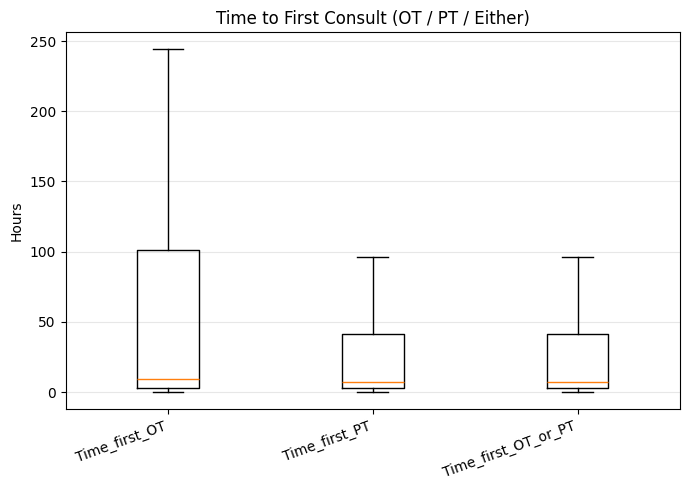

In [14]:
import matplotlib.pyplot as plt

def boxplot_cols(df, cols, title, ylabel="Hours", ylim=None):
    """Draw one boxplot for a list of column names."""
    data = [df[c].dropna() for c in cols]
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.boxplot(data, showfliers=False)   # hide outliers if you want cleaner boxes
    ax.set_xticklabels(cols, rotation=20, ha="right")
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.grid(axis="y", alpha=.3)
    plt.tight_layout()
    return ax

# Time to first consults 
time_cols = ["Time_first_OT", "Time_first_PT", "Time_first_OT_or_PT"]
boxplot_cols(final_df, time_cols, "Time to First Consult (OT / PT / Either)")

plt.show()

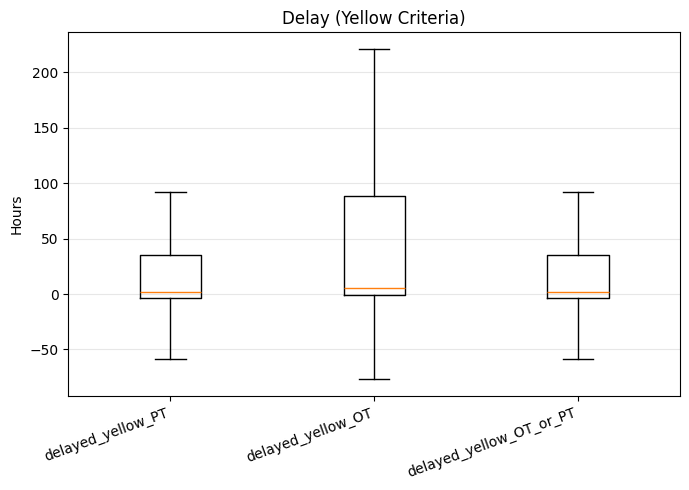

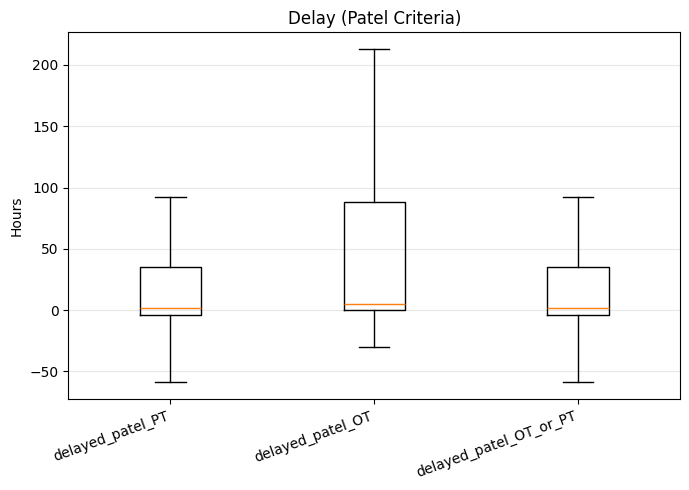

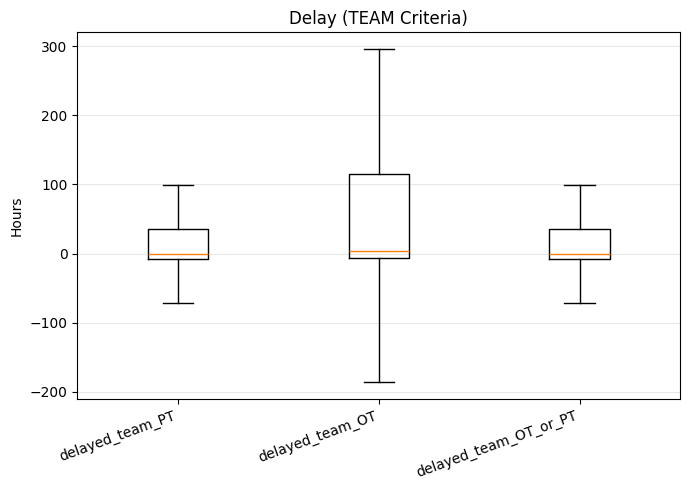

In [15]:
# Delays within each criterion 
yellow_cols = ["delayed_yellow_PT", "delayed_yellow_OT", "delayed_yellow_OT_or_PT"]
patel_cols = ["delayed_patel_PT", "delayed_patel_OT", "delayed_patel_OT_or_PT"]
team_cols = ["delayed_team_PT", "delayed_team_OT", "delayed_team_OT_or_PT"]

boxplot_cols(final_df, yellow_cols, "Delay (Yellow Criteria)")
boxplot_cols(final_df, patel_cols, "Delay (Patel Criteria)")
boxplot_cols(final_df, team_cols, "Delay (TEAM Criteria)")

plt.show()

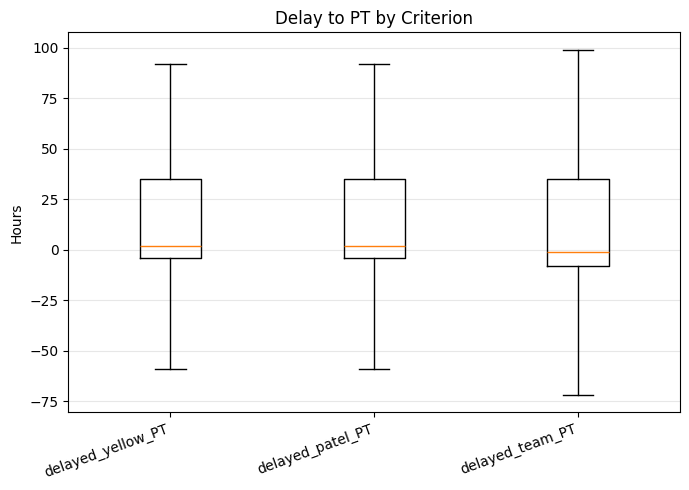

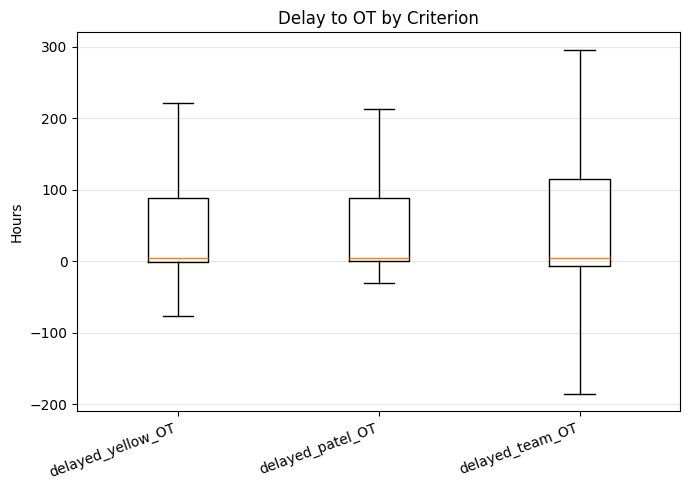

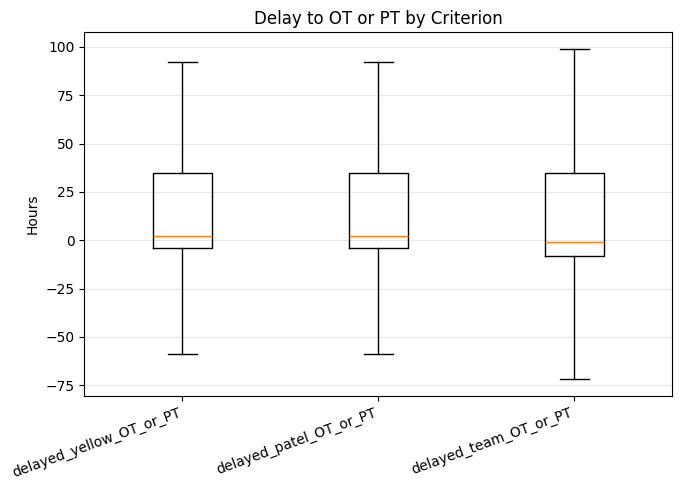

In [16]:
# Cross-criterion comparisons 
pt_delay_cols = ["delayed_yellow_PT", "delayed_patel_PT", "delayed_team_PT"]
ot_delay_cols = ["delayed_yellow_OT", "delayed_patel_OT", "delayed_team_OT"]
or_delay_cols = ["delayed_yellow_OT_or_PT", "delayed_patel_OT_or_PT", "delayed_team_OT_or_PT"]

boxplot_cols(final_df, pt_delay_cols, "Delay to PT by Criterion")
boxplot_cols(final_df, ot_delay_cols, "Delay to OT by Criterion")
boxplot_cols(final_df, or_delay_cols, "Delay to OT or PT by Criterion")

plt.show()

## CIF Plots of Time to Eligibility

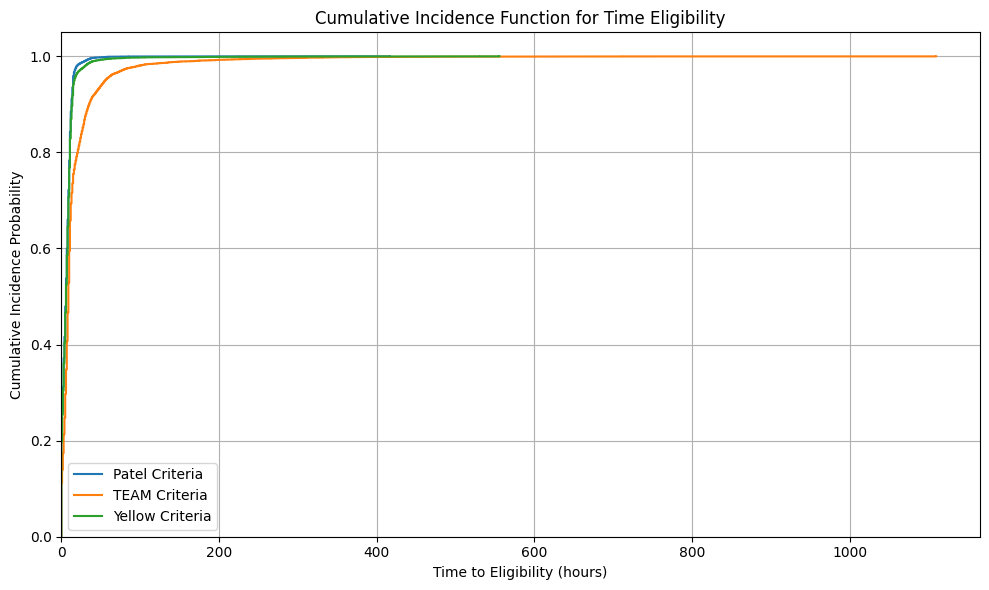

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cif(data, label, color=None):
    """Plot a basic CIF (empirical CDF) for time_eligibility"""
    times = data["time_eligibility"].dropna().sort_values()
    cum_prob = np.arange(1, len(times)+1) / len(times)
    plt.step(times, cum_prob, where="post", label=label, color=color)

# Plot all three
plt.figure(figsize=(10, 6))

plot_cif(patel, label="Patel Criteria")
plot_cif(team, label="TEAM Criteria")
plot_cif(yellow, label="Yellow Criteria")

# Customize plot
plt.title("Cumulative Incidence Function for Time Eligibility")
plt.xlabel("Time to Eligibility (hours)")
plt.ylabel("Cumulative Incidence Probability")
plt.ylim(0, 1.05)
plt.xlim(left=0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## CIF Plots of Time to First OT/PT/Either

In [18]:
def plot_cif_by_criteria(df, time_col, criteria_dict, title):
    plt.figure(figsize=(6, 4))

    for label, flag in criteria_dict.items():
        subset = df.drop_duplicates(subset="encounter_block")
        subset = df[(df[flag] == True) & (df[time_col].notna())]

        # Sort time and compute cumulative incidence
        times = np.sort(subset[time_col])
        cum_prob = np.arange(1, len(times) + 1) / len(times)

        # Step plot
        plt.step(times, cum_prob, where='post', label=label)

    plt.title(title)
    plt.xlabel("Time to First Consult from Ventilation (hours)")
    plt.ylabel("Cumulative Incidence Probability")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

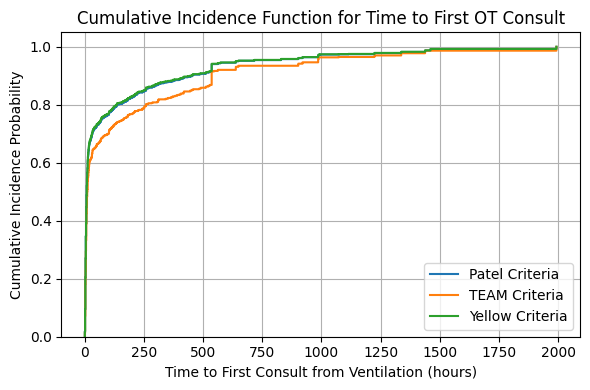

In [21]:
plot_cif_by_criteria(
    final_df,
    time_col="Time_first_OT",
    criteria_dict={
        "Patel Criteria": "patel_flag",
        "TEAM Criteria": "team_flag",
        "Yellow Criteria": "any_yellow_or_green_no_red"
    },
    title="Cumulative Incidence Function for Time to First OT Consult")

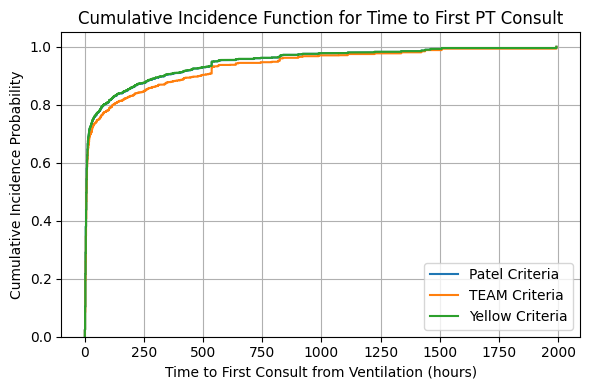

In [22]:
plot_cif_by_criteria(
    final_df,
    time_col="Time_first_PT",
    criteria_dict={
        "Patel Criteria": "patel_flag",
        "TEAM Criteria": "team_flag",
        "Yellow Criteria": "any_yellow_or_green_no_red"
    },
    title="Cumulative Incidence Function for Time to First PT Consult")

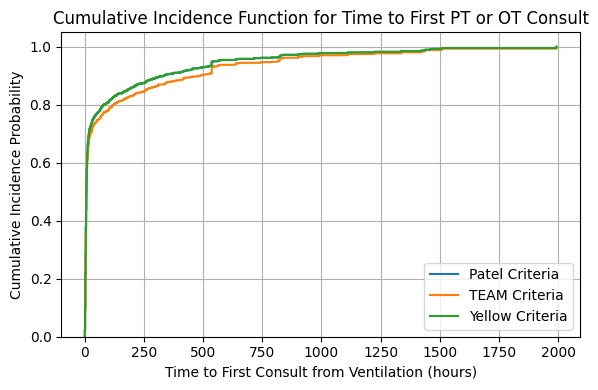

In [23]:
plot_cif_by_criteria(
    final_df,
    time_col="Time_first_OT_or_PT",
    criteria_dict={
        "Patel Criteria": "patel_flag",
        "TEAM Criteria": "team_flag",
        "Yellow Criteria": "any_yellow_or_green_no_red"
    },
    title="Cumulative Incidence Function for Time to First PT or OT Consult")

## CIF Plots of delayed time to First OT/PT/Either from eligibility

In [24]:
def plot_delay_cif(df, delay_dict, title):
    plt.figure(figsize=(6, 4))

    for label, col in delay_dict.items():
        subset = df.drop_duplicates(subset="encounter_block")
        subset = subset[subset[col].notna() & (subset[col] >= 0)]

        times = np.sort(subset[col])
        cum_prob = np.arange(1, len(times) + 1) / len(times)

        plt.step(times, cum_prob, where='post', label=label)

    plt.title(title)
    plt.xlabel("Delay from Eligibility to First Consult (hours)")
    plt.ylabel("Cumulative Incidence Probability")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

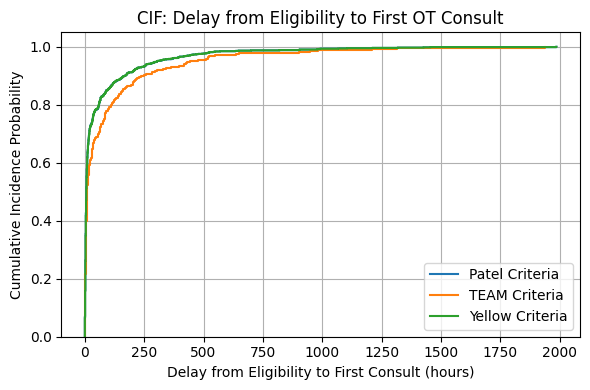

In [25]:
plot_delay_cif(
    final_df,
    delay_dict={
        "Patel Criteria": "delayed_patel_OT",
        "TEAM Criteria": "delayed_team_OT",
        "Yellow Criteria": "delayed_yellow_OT"
    },
    title="CIF: Delay from Eligibility to First OT Consult"
)

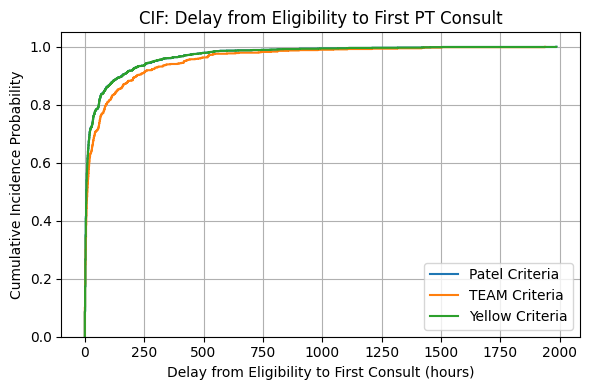

In [26]:
plot_delay_cif(
    final_df,
    delay_dict={
        "Patel Criteria": "delayed_patel_PT",
        "TEAM Criteria": "delayed_team_PT",
        "Yellow Criteria": "delayed_yellow_PT"
    },
    title="CIF: Delay from Eligibility to First PT Consult"
)

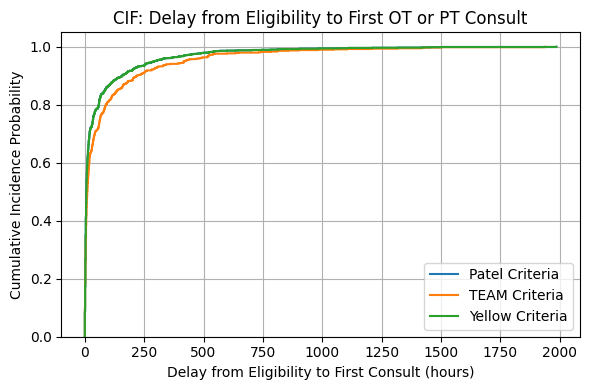

In [27]:
plot_delay_cif(
    final_df,
    delay_dict={
        "Patel Criteria": "delayed_patel_OT_or_PT",
        "TEAM Criteria": "delayed_team_OT_or_PT",
        "Yellow Criteria": "delayed_yellow_OT_or_PT"
    },
    title="CIF: Delay from Eligibility to First OT or PT Consult"
)